<!--<badge>--><a href="https://colab.research.google.com/github/Reversean/opt-labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Расчетное задание 4

## Анализ GERT-сети

Выполнил студент гр. 3540901/21501 Лихолетов М.Д.

Руководитель, к.т.н., доц. Сиднев А.Г.

## Задание

**Вариант 14Exp**

Дан граф GERT-сети:

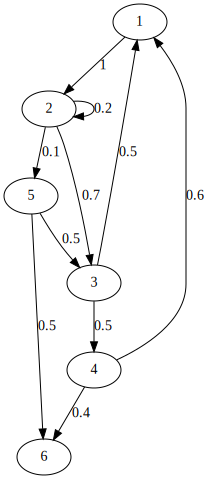

In [23]:
from graphviz import Digraph


class EdgeInfo:
    def __init__(self, start, end, p, m, d):
        self.start = start
        self.end = end
        self.p = p
        self.m = m
        self.d = d
        self.w = None

    def output_w(self):
        print('w{}{} = {}'.format(self.start, self.end, self.w))


edges = [
    EdgeInfo(1, 2, 1, 23, 16),
    EdgeInfo(2, 2, 0.2, 28, 16),
    EdgeInfo(2, 3, 0.7, 35, 18),
    EdgeInfo(2, 5, 0.1, 43, 25),
    EdgeInfo(3, 1, 0.5, 12, 4),
    EdgeInfo(3, 4, 0.5, 43, 9),
    EdgeInfo(4, 1, 0.6, 20, 9),
    EdgeInfo(4, 6, 0.4, 27, 25),
    EdgeInfo(5, 3, 0.5, 35, 36),
    EdgeInfo(5, 6, 0.5, 19, 16)
]

gert_dot = Digraph()

for i in range(1, 7):
    gert_dot.node(str(i))

for edge in edges:
    gert_dot.edge(str(edge.start), str(edge.end), str(edge.p))

gert_dot

Дуги графа обозначают возможную операцию $ij$. Время выполнения операции рассчитывается по показательному закону распределения. Для каждой операции заданы вероятность ее выполнения и параметры закона распределения (математическое ожидание $M$ и дисперсия $D$:

In [24]:
from pandas import DataFrame

param_table = DataFrame({
    'start': [edge.start for edge in edges],
    'end': [edge.end for edge in edges],
    'p': [edge.p for edge in edges],
    'M': [edge.m for edge in edges],
    'D': [edge.d for edge in edges],
})
param_table.set_index(['start', 'end'])

p   M   D
start end             
1     2    1.0  23  16
2     2    0.2  28  16
      3    0.7  35  18
      5    0.1  43  25
3     1    0.5  12   4
      4    0.5  43   9
4     1    0.6  20   9
      6    0.4  27  25
5     3    0.5  35  36
      6    0.5  19  16

Задание состоит из двух частей:

1. Используя методику GERT, изложенную в книге «Методы анализа сетей», найти:

   1. Вероятность выхода в завершающий узел графа (для всех вариантов узел 6)
   2. Производящую функцию длительности процесса от начального узла до завершающего узла (получить аналитическое выражение)
   3. Математическое ожидание длительности процесса от начального узла до завершающего узла
   4. Дисперсию ожидание длительности процесса от начального узла до завершающего узла
   5. Начальные моменты первых 10 порядков.

   В отчете перечислить все петли всех порядков, обнаруженные на графе, выписать уравнение Мейсона, получить решение для $W_E(s)$ и найти требуемые параметры.

2. Повторить пункты задания 2, 3, 4, 5 используя методику анализа потокового графа, основанную на обработке матрицы передач (Branch Transmittance Matrix).


## 1. Методика GERT

Основной целью использования GERT-сети в сетевом анализе является вычисление:

- математического ожидания и дисперсии длительности процесса от начального узла (1) до завершающего (6);
- вероятность выхода процесса в завершающий узел.

В сети каждый узел соответствует независимой переменной $x_i$

Каждую дугу в сети можно сопоставить с соответствующей $W$-функцией (коэффициент пропускания):

$$
W_{ij}(s) = p_{ij} M_{ij}(s)
$$

где $i$ – стартовый узел, $j$ – конечный узел, $p_{ij}$ – вероятность выполнения операции, $M_{ij}(s)$ – производящая функция моментов.

Т.к. условиями задано, что время любой операции соответствует показательному закону распределения, то производящая функция моментов имеет следующий вид:

$$
M_{ij}(s) = \frac{1}{1 - m_{ij} * s}
$$

где $m$ – математическое ожидание соответствующей операции.

В исходную открытую сеть требуется добавить дополнительную дугу, соединяющую конечный узел со стартовым. Делается это для того, чтобы образовать петли, включающие начальный и конечный узлы, образуя замкнутую сеть:

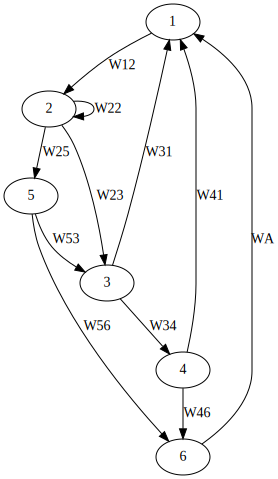

In [25]:
cycle_gert_dot = Digraph()

for i in range(1, 7):
    cycle_gert_dot.node(str(i))

for edge in edges:
    cycle_gert_dot.edge(str(edge.start), str(edge.end), 'W{}{}'.format(edge.start, edge.end))

cycle_gert_dot.edge('6', '1', 'WA')

cycle_gert_dot

Для всех замкнутых сетей действует правило Мейсона, имеющее следующий вид:

$$
1 - \sum T(L_1) + \sum T(L_2) - \sum T(L_3) + ... + (-1)^m \sum T(L_m) + ... = 0
$$

где $\sum T(L_i)$ – сумма эквивалентных коэффициентов пропускания для всех петель $i$-го порядка.

Благодаря этому правилу, на основе пропускного коэффициента дуги, соединяющей конечный и стартовый узлы ($W_A(s)$), можно вычислить пропускной коэффициент исходной сети ($W_E(s)$):

\begin{gather}
1 - W_A(s) W_E(s) = 0;\\
W_A(s) = \frac{1}{W_E(s)}
\end{gather}

Чтобы раскрыть правило Мейсона и вычислить пропускной коэффициент исходной сети, требуется найти все петли всех порядков в сети.

**Петли первого порядка:**

- $L_1 = \{ W_{12} W_{23} W_{31} \}$
- $L_2 = \{ W_{12} W_{23} W_{34} W_{41} \}$
- $L_3 = \{ W_{12} W_{23} W_{34} W_{46} \frac{1}{W_e} \}$
- $L_4 = \{ W_{12} W_{25} W_{53} W_{31} \}$
- $L_5 = \{ W_{12} W_{25} W_{53} W_{34} W_{41} \}$
- $L_6 = \{ W_{12} W_{25} W_{53} W_{34} W_{46} \frac{1}{W_e} \}$
- $L_7 = \{ W_{12} W_{25} W_{56} \frac{1}{W_e} \}$
- $L_8 = \{ W_{22} \}$

Т.к. все петли первого порядка имеют между собой пересечения (имеют общие узлы с другими петлями этого же порядка), то выходит, что 1 – это максимальный порядок петель в сети.

Далее потребуется объявить W-функции:

In [26]:
from sympy import symbols

s = symbols('s')

for edge in edges:
    edge.w = edge.p / (1 - edge.m * s)
    edge.output_w()

w12 = 1/(1 - 23*s)
w22 = 0.2/(1 - 28*s)
w23 = 0.7/(1 - 35*s)
w25 = 0.1/(1 - 43*s)
w31 = 0.5/(1 - 12*s)
w34 = 0.5/(1 - 43*s)
w41 = 0.6/(1 - 20*s)
w46 = 0.4/(1 - 27*s)
w53 = 0.5/(1 - 35*s)
w56 = 0.5/(1 - 19*s)


Теперь можно выразить и упростить $W_E(s)$ по правилу Мейсона:

$$
W_e(s) = \frac{w_{12} w_{23} w_{34} w_{46} + w_{12} w_{25} w_{53} w_{34} w_{46} + w_{12} w_{25} w_{56}}{1 - w_{12} w_{23} w_{31} - w_{12} w_{23} w_{34} w_{41} - w_{12} w_{25} w_{53} w_{31} - w_{12} w_{25} w_{53} w_{34} w_{41} - w_{22}}
$$

In [27]:
from sympy import simplify

We = (edges[0].w * edges[2].w * edges[5].w * edges[7].w + edges[0].w * edges[3].w * edges[8].w * edges[5].w * edges[7].w + edges[0].w * edges[3].w * edges[9].w) \
     / (1 - edges[0].w * edges[2].w * edges[4].w - edges[0].w * edges[2].w * edges[5].w * edges[6].w - edges[0].w * edges[3].w * edges[8].w * edges[4].w - edges[0].w * edges[3].w * edges[8].w * edges[5].w * edges[6].w - edges[1].w)

We = simplify(We)

We

(-13653360.0*s**6 + 4289997.6*s**5 - 551831.88*s**4 + 37111.87*s**3 - 1369.33*s**2 + 26.12*s - 0.2)/(5131205755200.0*s**9 - 1899237278400.0*s**8 + 304816057964.0*s**7 - 27708711841.6*s**6 + 1563256970.96*s**5 - 56272711.57*s**4 + 1272707.655*s**3 - 16905.62*s**2 + 110.795*s - 0.2)

Известно, что $M_E(0) = 1$, т.е. учитывая, что $W_E(s) = p_E M_E(s)$, можно считать, что $p_E = W_E(0)$, из чего можно следует:

$$
M_E(s) = \frac{W_E(s)}{p_E} = \frac{W_E(s)}{W_E(0)}
$$

где $p_E$ вероятность выхода в завершающий узел.

Таким образом можно найти вероятность выхода в завершающий узел:

In [28]:
We0 = We.subs(s, 0)

print('p = {}'.format(We0))

p = 1.00000000000000


Зная функцию для нахождения $W_E(s)$, можно найти функцию $M_E(s)$:

In [29]:
Me = We / We0

Me

1.0*(-13653360.0*s**6 + 4289997.6*s**5 - 551831.88*s**4 + 37111.87*s**3 - 1369.33*s**2 + 26.12*s - 0.2)/(5131205755200.0*s**9 - 1899237278400.0*s**8 + 304816057964.0*s**7 - 27708711841.6*s**6 + 1563256970.96*s**5 - 56272711.57*s**4 + 1272707.655*s**3 - 16905.62*s**2 + 110.795*s - 0.2)

Полагая, что $s = 0$, можно продифференцировать функцию $M_E(s)$.

Первая производная является первым моментом $\mu_{1E}$ и математическим ожиданием времени выполнения сети:

In [30]:
from sympy import diff

m1 = diff(Me, s)
m1 = m1.subs(s, 0)

print('M = {}'.format(m1))

M = 423.375000000000


Дисперсию времени выполнения сети можно вычислить следующим образом:

$$
\sigma^2 = \mu_{2E} - \mu_{1E}^2
$$

где $\mu_{2E}$ – второй момент (вторая производная).

In [31]:
m2 = diff(Me, s, 2)
m2 = m2.subs(s, 0)
D = m2 - m1 ** 2

print('D = {}'.format(D))

D = 134469.040625000


Итого были получены следующие результаты:

- Вероятность выхода в завершающий узел равна 100%
- Математическое ожидание времени выхода процесса сети равно 423.38
- Дисперсия времени выхода процесса сети равно 134469.04

Также требуется вычислить начальные моменты первых 10 порядков:

In [32]:
moment_ed = {
    '#': [],
    'value': []
}

for i in range(1, 11):
    m = diff(Me, s, i)
    moment_ed['#'].append(i)
    moment_ed['value'].append(m.subs(s, 0))

moment_ed_table = DataFrame(moment_ed)
moment_ed_table.set_index('#')

## 2. Методика анализа потокового графа

Методика анализа потокового графа также берет за основу правило Мейсона для анализа сети, однако вместо того, чтобы строить формулу на основе подсчета петлей в сети, используется матрица переходов.

Данный подход призван уменьшить количество возможных человеческих ошибок при подсчете петель с большим порядком в масштабных сетях.

Для начала требуется составить матрицу переходов:

In [33]:
from sympy import IndexedBase, zeros

q = IndexedBase('q')
w = IndexedBase('w')

Q = zeros(6, 6)

for edge in edges:
    Q[edge.start - 1, edge.end - 1] = q[edge.start, edge.end]

Q[5, 0] = w[6, 1]

Q

Matrix([
[      0, q[1, 2],       0,       0,       0,       0],
[      0, q[2, 2], q[2, 3],       0, q[2, 5],       0],
[q[3, 1],       0,       0, q[3, 4],       0,       0],
[q[4, 1],       0,       0,       0,       0, q[4, 6]],
[      0,       0, q[5, 3],       0,       0, q[5, 6]],
[w[6, 1],       0,       0,       0,       0,       0]])

На основе матрицы переходов требуется построить матрицу коэффициентов:

$$
A = I - Q^T
$$

где $I$ – диагональная матрица с единицами в элементах на диагонали, $A$ – матрица коэффициентов.

In [34]:
from sympy import eye

A = eye(6) - Q.T

A

Matrix([
[       1,           0, -q[3, 1], -q[4, 1],        0, -w[6, 1]],
[-q[1, 2], 1 - q[2, 2],        0,        0,        0,        0],
[       0,    -q[2, 3],        1,        0, -q[5, 3],        0],
[       0,           0, -q[3, 4],        1,        0,        0],
[       0,    -q[2, 5],        0,        0,        1,        0],
[       0,           0,        0, -q[4, 6], -q[5, 6],        1]])

Для репрезентации связей между узлами сети на основе матрицы коэффициентов можно использовать матричную систему уравнений:

\begin{gather}
AX = Y\\
\end{gather}
$$
X =
\begin{bmatrix}
    X_1\\
    X_2\\
    X_3\\
    X_4\\
    X_5\\
    X_6
\end{bmatrix}
\quad
Y =
\begin{bmatrix}
    0\\
    0\\
    0\\
    0\\
    0\\
    0
\end{bmatrix}
$$

где $A$ – полученная матрица коэффициентов, $X$ – вектор узлов сети, $Y$ – вектор, обозначающий начальные узлы (1 для начального узел, 0 для всех остальных узлов).

Т.к. сеть является замкнутой, вектор $Y$ состоит из 0, а значит $AX = 0$. При таких условиях известно, что можно найти пропускной коэффициент сети на основе полученной матрицы коэффициентов следующим образом:

$$
W_e(s) = \frac{\frac{\delta det(A)}{\delta \omega_{61}}}{det(A \vert_{\omega_{61} = 0})}
$$

Прежде всего нужно найти определитель матрицы $A$:

In [35]:
det_A = A.det()

det_A

-q[1, 2]*q[2, 3]*q[3, 1] - q[1, 2]*q[2, 3]*q[3, 4]*q[4, 1] - q[1, 2]*q[2, 3]*q[3, 4]*q[4, 6]*w[6, 1] - q[1, 2]*q[2, 5]*q[3, 1]*q[5, 3] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 1]*q[5, 3] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 6]*q[5, 3]*w[6, 1] - q[1, 2]*q[2, 5]*q[5, 6]*w[6, 1] - q[2, 2] + 1

Далее потребуется найти производную детерминанта по $w_{61}$:

In [36]:
diff_det_A = diff(det_A, w[6, 1])

diff_det_A

-q[1, 2]*q[2, 3]*q[3, 4]*q[4, 6] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 6]*q[5, 3] - q[1, 2]*q[2, 5]*q[5, 6]

Также требуется рассчитать детерминант при $w_{61} = 0$:

In [37]:
det_A0 = det_A.subs(w[6, 1], 0)

det_A0

-q[1, 2]*q[2, 3]*q[3, 1] - q[1, 2]*q[2, 3]*q[3, 4]*q[4, 1] - q[1, 2]*q[2, 5]*q[3, 1]*q[5, 3] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 1]*q[5, 3] - q[2, 2] + 1

Теперь можно рассчитать функцию пропускного коэффициента сети:

In [38]:
We_det = diff_det_A / det_A0

We_det

(-q[1, 2]*q[2, 3]*q[3, 4]*q[4, 6] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 6]*q[5, 3] - q[1, 2]*q[2, 5]*q[5, 6])/(-q[1, 2]*q[2, 3]*q[3, 1] - q[1, 2]*q[2, 3]*q[3, 4]*q[4, 1] - q[1, 2]*q[2, 5]*q[3, 1]*q[5, 3] - q[1, 2]*q[2, 5]*q[3, 4]*q[4, 1]*q[5, 3] - q[2, 2] + 1)

Небольшое отступление. На данном этапе нужно было сопоставить полученную функцию с функцией, составленной вручную в 1 части. Функции должны были быть эквивалентными, однако оказалось, что автор забыл добавить в функцию из 1 части одну петлю. Это подтверждает вышесказанное утверждение, что метод на основе обработки матрицы переходов позволяет избежать возможных ошибок с учетом петель.

Далее требуется в функции $W$-функции вместо $q_{ij}$, а затем проделать те же этапы, что и в 1 части.

In [39]:
for edge in edges:
    We_det = We_det.subs(q[edge.start, edge.end], edge.w)

We_det = simplify(We_det)

We_det

(13653360.0*s**6 - 4289997.6*s**5 + 551831.88*s**4 - 37111.87*s**3 + 1369.33*s**2 - 26.12*s + 0.2)/(5131205755200.0*s**9 - 1899237278400.0*s**8 + 304816057964.0*s**7 - 27708711841.6*s**6 + 1563256970.96*s**5 - 56272711.57*s**4 + 1272707.655*s**3 - 16905.62*s**2 + 110.795*s - 0.2)

Нахождение $W_E(s)$ и соответственно вероятности выхода в конечное состояние сети при $s = 0$:

In [40]:
We0_det = We_det.subs(s, 0)

print('p = {}'.format(We0_det))

p = -1.00000000000000


Нахождение $M_E(s)$:

In [41]:
Me_det = We_det / We0_det

Me_det

-1.0*(13653360.0*s**6 - 4289997.6*s**5 + 551831.88*s**4 - 37111.87*s**3 + 1369.33*s**2 - 26.12*s + 0.2)/(5131205755200.0*s**9 - 1899237278400.0*s**8 + 304816057964.0*s**7 - 27708711841.6*s**6 + 1563256970.96*s**5 - 56272711.57*s**4 + 1272707.655*s**3 - 16905.62*s**2 + 110.795*s - 0.2)

Нахождение математического ожидания:

In [42]:
m1_det = diff(Me_det, s)
m1_det = m1_det.subs(s, 0)

print('M = {}'.format(m1_det))

M = 423.375000000000


Нахождение дисперсии:

In [43]:
m2_det = diff(Me_det, s, 2)
m2_det = m2_det.subs(s, 0)
D_det = m2_det - m1_det ** 2

print('D = {}'.format(D_det))

D = 134469.040625000


Как и ожидалось результаты получились полностью идентичными результатам, полученным в 1 части.

## Треугольный закон распределения

Попробуем найти первые 10 начальных моментов, но используя треугольный закон распределения.

Достаточно использовать функцию, полученную ранее, и заменив производящую функцию моментов:

$$
M_{ij}(s) = \bigg[ \frac{2 (e^{sb/2} - e^{sa/2})}{(b - a) s} \bigg]^2\\
a = 0.4m\\
b = 1.6m
$$

где $m$ – математическое ожидание.

In [44]:
from sympy import exp

We_det_triangular = diff_det_A / det_A0

for edge in edges:
    a = 0.4 * edge.m
    b = 1.6 * edge.m
    w = (2 * (exp(s * a / 2) - exp(s * b / 2)) / ((b - a) * s)) ** 2
    We_det_triangular = We_det_triangular.subs(q[edge.start, edge.end], w)

We_det_triangular = simplify(We_det_triangular)

We_det_triangular

In [45]:
We0_det_triangular = We_det_triangular.subs(s, 0)

We0_det_triangular

In [46]:
Me_det_triangular = We_det_triangular / We0_det_triangular

In [47]:
moment_triangular = {
    '#': [],
    'value': []
}

for i in range(1, 11):
    m = diff(Me_det_triangular, s, i)
    moment_triangular['#'].append(i)
    moment_triangular['value'].append(m.subs(s, 0))

moment_triangular_table = DataFrame(moment_triangular)
moment_triangular_table.set_index('#')

## Закон распределения равномерной плоскости

Также попробуем найти первые 10 начальных моментов закон распределения равномерной плоскости:

$$
M_{ij}(s) = \frac{2 (e^{sa} - e^{sb})}{(a - b) s}\\
a = 0.4m\\
b = 1.6m
$$

In [ ]:
from sympy import exp

We_det_uniform = diff_det_A / det_A0

for edge in edges:
    a = 0.4 * edge.m
    b = 1.6 * edge.m
    w = (exp(s * a) - exp(s * b)) / ((a - b) * s)
    We_det_uniform = We_det_uniform.subs(q[edge.start, edge.end], w)

We_det_uniform = simplify(We_det_uniform)

We_det_uniform

In [ ]:
We0_det_uniform = We_det_uniform.subs(s, 0)

We0_det_uniform

In [ ]:
Me_det_uniform = We_det_uniform / We0_det_uniform

In [ ]:
moment_uniform = {
    '#': [],
    'value': []
}

for i in range(1, 11):
    m = diff(Me_det_uniform, s, i)
    moment_uniform['#'].append(i)
    moment_uniform['value'].append(m.subs(s, 0))

moment_uniform_table = DataFrame(moment_uniform)
moment_uniform_table.set_index('#')

## Вывод

В данной работе были рассмотрены 2 метода для анализа GERT-сетей.

Первый метод подразумевал составления функции расчета пропускного коэффициента сети вручную с нахождением петлей всех порядков в сети. Это вызвало некоторые неудобства, т.к. легко допустить ошибку и не учесть некоторые петли, из-за чего получить ошибочный результат.

Второй метод, основанный на матрице переходов решает эту проблему. Так например автору при анализе этим методом удалось найти ошибку в анализе, сделанном первым методом. Кроме того отображение в виде матрицы является более удобным, чем в виде перечисляемых петель разных порядков.